# Import Packages

In [34]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
import warnings
from keras import backend as K
warnings.filterwarnings("ignore")
#K.tensorflow_backend._get_available_gpus()
from wordcloud import WordCloud, STOPWORDS

In [2]:
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.1.0
tf.keras.__version__ is: 2.2.4-tf


# Import training and testing dataset 

In [3]:
train_df = pd.read_csv(r'D:\Springboard\Github\Data-NLP-Toxic Classification\train.csv', index_col='id',engine='python')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [4]:
test_df = pd.read_csv(r'D:\Springboard\Github\Data-NLP-Toxic Classification\test.csv',index_col='id',engine='python')
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


# Preprocessing the Training and Testing Dataset 

In [5]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

In [6]:
%%time 
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

Wall time: 14min 46s


In [7]:
train_df['preprocessed_text'].head()

id
59848    cool like would want mother read realli great ...
59849    thank would make life lot less anxieti induc k...
59852              urgent design problem kudo take impress
59855                        someth abl instal site releas
59856                                 haha guy bunch loser
Name: preprocessed_text, dtype: object

In [8]:
%%time 
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

Wall time: 35.1 s


In [9]:
test_df['preprocessed_text']

id
7097320              integr mean pay debt appli presid trump
7097321                   malfeas administr board wast money
7097322    rmiller101 spoken like true elitist look bud a...
7097323    paul thank kind word inde strong belief hide b...
7097324    sorri miss high school eisenhow sent troop vie...
                                 ...                        
7194635              lose job promot mis inform harm student
7194636    thin project meant lower fire danger improv wi...
7194637                hope millenni happi put airhead charg
7194638    think kellyann conway k trump whisper play lar...
7194639    still figur pizza ak cost pizza washington ida...
Name: preprocessed_text, Length: 97320, dtype: object

# Feature Engineering

Define the predicted variable and targer varible for the modeling  

In [10]:
X = train_df[['preprocessed_text']]
y = train_df[['target']]

In [11]:
X_train,X_cv, y_train, y_cv = train_test_split(X,y)
print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(1353655, 1)
(451219, 1)
(1353655, 1)
(451219, 1)


In [12]:
X_train.head()

,preprocessed_text
id,
6272162,far folk accord ctv news ask team polic invest...
986737,judg make law interpret suppos base constitut ...
5350770,theori backfir bad data dnc
414153,addict ill diseas addict first agre war drug a...
6226993,ellen need anoth ordin anoth sinc valid order ...


In [13]:
X_cv.head()

,preprocessed_text
id,
6170624,amazon say start make car windmil money would ...
880610,legisl hang sign offic door say lobbyist allow...
5972558,may even awar comment whenev run argument actu...
499049,pretti sure comment time former pmo record ope...
343063,would pay prefer incom tax


In [14]:
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


## Save the dataset  separately for modeling 

In [60]:
X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

# Modeling 

## Bag of Words (BoW):

In [15]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


### SDBGRegressor

In [ ]:
#### Hyperparameters Tuning

In [65]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cross valivation set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.02283342412714813
Mean Squared Error on cross valivation set:  0.022858673831910276
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.04078823348487108
Mean Squared Error on cross valivation set:  0.022935830115709262
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.024503642871725736
Mean Squared Error on cross valivation set:  0.024412166674371037
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.022481244349716767
Mean Squared Error on cross valivation set:  0.022663103722944018
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03148370157865611
Mean Squared Error on cross valivation set:  0.0313601558235058
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.02325184388193145
Mean Squared Error on c

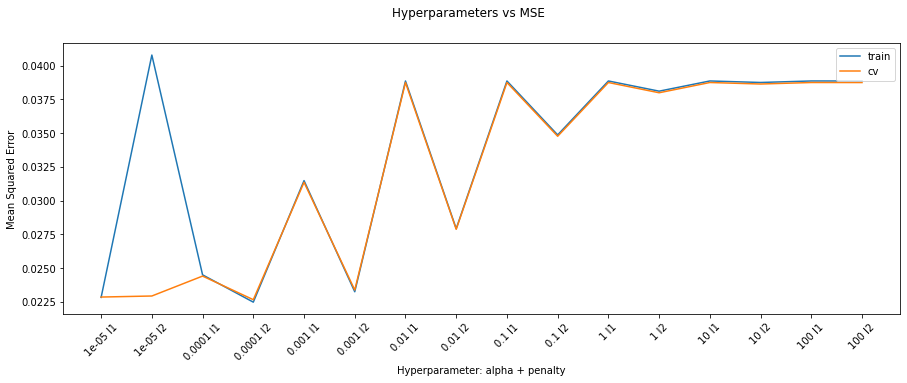

In [66]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [67]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

#### Feature Importance

In [69]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_name = cnt_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'],index = feat_name)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idiot,0.416785
stupid,0.344826
moron,0.313511
pathet,0.286502
crap,0.274837
hypocrit,0.263083
dumb,0.261428
scum,0.255173
ass,0.254764
shit,0.251900


In [70]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
stupid stupid,-0.130447
knee jerk,-0.072097
fool peopl,-0.062510
black white,-0.052995
ignor fact,-0.044875
winner loser,-0.043659
dumb dumb,-0.040778
ha ha,-0.040338
left left,-0.040021
black market,-0.039591


### Decision Tree

#### Hyperparameter Tuning

In [71]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.033125317764581434
Mean Squared Error on cv set:  0.03306553567365372
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.033125317764581434
Mean Squared Error on cv set:  0.03306553567365373
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.033127478065556284
Mean Squared Error on cv set:  0.03306466655483982
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03204844517902825
Mean Squared Error on cv set:  0.03196678107164001
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03205127579496766
Mean Squared Error on cv set:  0.03196569858997583
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on tra

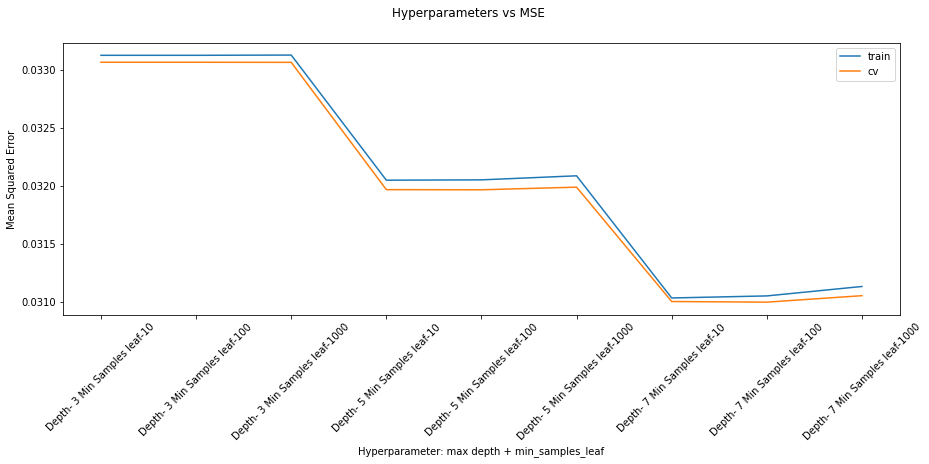

In [72]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [73]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [ ]:
#### Feature Importance

In [78]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_name)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.395693
idiot,0.264344
fool,0.069219
pathet,0.066702
moron,0.063162
white,0.059315
hypocrit,0.056186
racist,0.005658
would,0.003902
year,0.003674


## Term Frequency - Inverse Document Frequency (TFIDF) :

In [92]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


### SGDRegressor

#### Hyperparameter Tuning:

In [94]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.025298613603030283
Mean Squared Error on cv set:  0.025184444151453475
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.02393785169340777
Mean Squared Error on cv set:  0.023872550533555893
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.029763599842912578
Mean Squared Error on cv set:  0.029630895437448897
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.02505576447929674
Mean Squared Error on cv set:  0.024973232806790802
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.038354919406429044
Mean Squared Error on cv set:  0.03822724759161631
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.030099755022771145
Mean Squared Error on cv set:  0.029983236479047555
**************************************

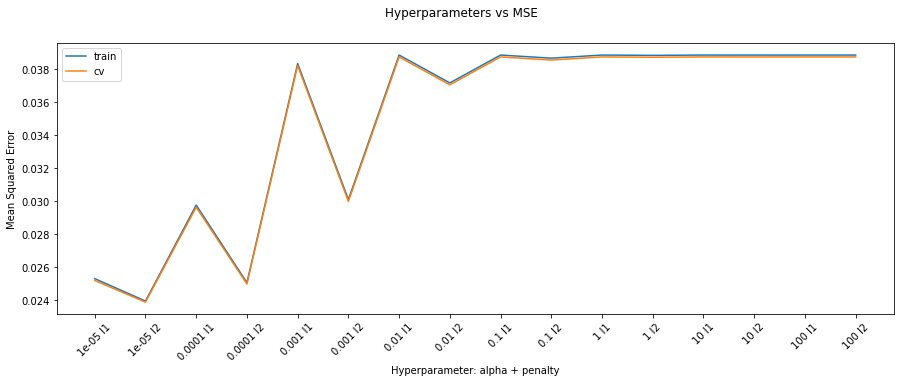

In [95]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

#### Feature Importance:

In [96]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,1.568197
idiot,1.266598
fool,0.671890
ignor,0.603454
dumb,0.595194
pathet,0.583067
moron,0.572010
ridicul,0.562338
loser,0.560238
liar,0.527485


In [97]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.094631
interest,-0.086150
agre,-0.078112
stori,-0.077787
good,-0.073536
new,-0.070769
great,-0.069402
may,-0.069375
point,-0.066561
differ,-0.066329


### Decision Trees:

#### Hyperparameter Tuning:

In [98]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03291622692096219
Mean Squared Error on cv set:  0.03286100080654973
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.032916226920962195
Mean Squared Error on cv set:  0.03286100080654973
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.032916226920962195
Mean Squared Error on cv set:  0.032861000806549724
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03177945578843031
Mean Squared Error on cv set:  0.03170347816144167
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.031780234835429765
Mean Squared Error on cv set:  0.03170367642354674
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on tr

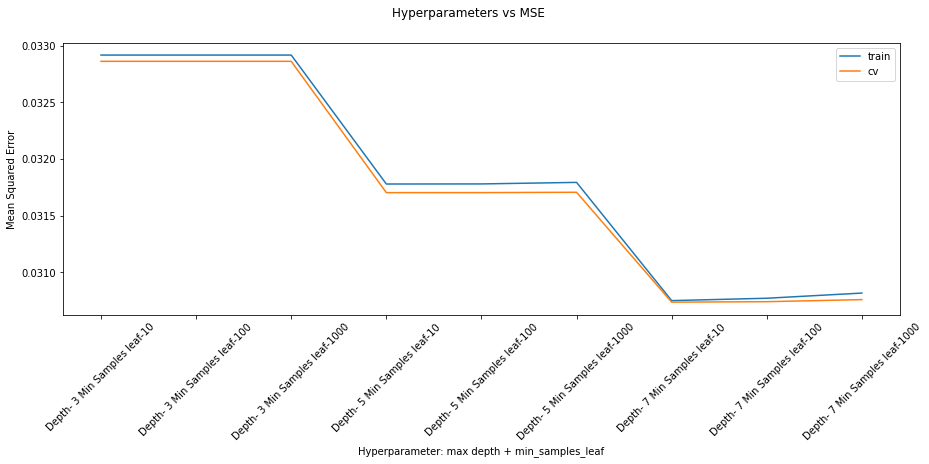

In [99]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

#### Feature Importance

In [100]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.403920
idiot,0.267523
fool,0.073506
pathet,0.068439
moron,0.064143
white,0.058366
hypocrit,0.054309
racist,0.005070
fool peopl,0.000979
ignor,0.000620


### LSTM:

In [29]:
class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.
        
        # Append additional values to make lengths equal.
        whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)
        
        return whole

In [30]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import DenseFeatures

lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

In [31]:
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

In [23]:
print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)

(1353655, 350)
(451219, 350)
(97320, 350)


In [85]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.text import one_hot


In [33]:
# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words,embedding_vecor_length, input_length=350))
model.add(LSTM(128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())

TypeError: The added layer must be an instance of class Layer. Found: <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000001B1C0860908>

In [ ]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(lstm_train, y_train, nb_epoch=5,
                    batch_size=2048, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

## Conclusions:

In [ ]:
- BagOfWords:
1.SGDRegressor:
Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
Train MSE Loss: 0.02281
CV MSE Loss: 0.02326
2.Decision Tree:
Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
Train MSE Loss: 0.0310
CV MSE Loss: 0.03128
    
    
- TFIDF:
1.SGDRegressor:
Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
Train MSE Loss: 0.02556
CV MSE Loss: 0.02584
2.Decision Tree:
Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
Train MSE Loss: 0.03073
CV MSE Loss: 0.03122
    
    
- LSTM:
Train MSE Loss: 0.0157
CV MSE Loss: 0.0162